# GRPO Snapshot and Branching Tutorial

This notebook demonstrates the advanced GRPO features: snapshot/restore and branching functionality.

## What You'll Learn:
- **Snapshot System**: Save environment states for multi-turn rollouts
- **Branching Mode**: Run multiple CARLA instances in parallel
- **Trajectory Collection**: Collect multiple trajectories from the same state
- **Branch Selection**: Select best trajectory and continue exploration

### Prerequisites:
- Complete the "02_grpo_carla_interface.ipynb" notebook first
- CARLA server running at `http://localhost:8080`

### Key Concepts:
- **Snapshot**: Save complete environment state at decision points
- **Branching**: Create parallel environments from same snapshot
- **Multi-turn Rollouts**: Explore different actions from same state
- **Best Trajectory Selection**: Choose optimal path based on rewards

In [1]:
import subprocess, re

def kill_carla_processes_on_gpu(gpu_index: int = 0):
    """Kill CARLA processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\+G\s+.*CarlaUE4'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No CarlaUE4 processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing CarlaUE4 process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing CARLA processes: {e}")

def kill_python_processes_on_gpu(gpu_index: int = 0):
    """Kill Python processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\s+.*bin/python'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No python processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing python process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing Python processes: {e}")

def cleanup_gpu_processes():
    """Clean up GPU processes"""
    for gpu_id in [0, 1]:
        kill_carla_processes_on_gpu(gpu_id)
        kill_python_processes_on_gpu(gpu_id)

cleanup_gpu_processes()

No CarlaUE4 processes found on GPU 0
No python processes found on GPU 0
Killing CarlaUE4 process with PID 284074 on GPU 1
No python processes found on GPU 1


In [2]:
import logging, os, signal, subprocess, time, shutil
from typing import Set, List  # add this


logger = logging.getLogger(__name__)

def _pids_listening_on_port(port: int, only_mine: bool = True) -> Set[int]:
    """
    Return PIDs listening on `port`. Prefers `lsof`, falls back to `ss` if available.
    Only returns LISTEN sockets, not established connections.
    """
    pids = set()

    if shutil.which("lsof"):
        # -iTCP -sTCP:LISTEN limits to listening TCP sockets
        cmd = ["lsof", "-nP", "-tiTCP:%d" % port, "-sTCP:LISTEN"]
        if only_mine:
            cmd.insert(1, "-u")
            cmd.insert(2, os.getlogin())
        res = subprocess.run(cmd, capture_output=True, text=True)
        if res.returncode == 0 and res.stdout.strip():
            pids.update(int(x) for x in res.stdout.strip().splitlines() if x.strip().isdigit())
        return pids

    if shutil.which("ss"):
        # Linux: parse `ss` output for LISTEN sockets
        # Example line: LISTEN 0 128 0.0.0.0:2000 ... users:(("CarlaUE4",pid=1234,fd=42))
        res = subprocess.run(["ss", "-lptn"], capture_output=True, text=True)
        if res.returncode == 0:
            for line in res.stdout.splitlines():
                if f":{port} " in line or line.endswith(f":{port}") or f":{port}," in line:
                    if "LISTEN" not in line:
                        continue
                    # Pull out pid=NNN tokens
                    for tok in line.split():
                        if tok.startswith("pid=") and tok[4:].rstrip(",)") .isdigit():
                            pids.add(int(tok[4:].rstrip(",)")))
    return pids

def _graceful_kill(pids: Set[int], grace: float = 2.5):
    """Send SIGTERM, wait up to `grace` seconds, then SIGKILL leftovers."""
    if not pids:
        return
    me = os.getpid()
    pids = {pid for pid in pids if pid != me}
    if not pids:
        return

    for pid in pids:
        try:
            os.kill(pid, signal.SIGTERM)
            logger.info(f"SIGTERM sent to PID {pid}")
        except ProcessLookupError:
            pass
        except PermissionError:
            logger.warning(f"Permission denied sending SIGTERM to {pid}")

    deadline = time.time() + grace
    remaining = set(pids)
    while time.time() < deadline and remaining:
        for pid in list(remaining):
            try:
                os.kill(pid, 0)
            except ProcessLookupError:
                remaining.discard(pid)
        time.sleep(0.2)

    for pid in list(remaining):
        try:
            os.kill(pid, signal.SIGKILL)
            logger.info(f"SIGKILL sent to stubborn PID {pid}")
        except ProcessLookupError:
            pass
        except PermissionError:
            logger.warning(f"Permission denied sending SIGKILL to {pid}")

def clean_ports(ports: List[int], only_mine: bool = True):
    """Kill processes LISTENing on the given ports."""
    all_pids = set()
    for port in ports:
        try:
            pids = _pids_listening_on_port(port, only_mine=only_mine)
            if pids:
                logger.info(f"Port {port} in use by PIDs {sorted(pids)}")
                all_pids.update(pids)
        except Exception as e:
            logger.debug(f"Error checking port {port}: {e}")

    if all_pids:
        _graceful_kill(all_pids)
    else:
        logger.info("No listeners found on target ports.")

def clean_all(num_services: int = 2):
    logger.info(f"Starting {num_services} CARLA services...")

    # 0) Clean named processes (gentle first, then escalate)
    kill_names = ["carla_server.py", "microservice_manager.py", "CarlaUE4", "server_manager.py"]
    for name in kill_names:
        # Try pkill TERM first
        subprocess.run(["pkill", "-f", name], capture_output=True)
        time.sleep(0.2)
        # Escalate only if still present
        subprocess.run(["pkill", "-9", "-f", name], capture_output=True)

    # 1) Clean precise ports (LISTEN only). Adjust lists to your topology.
    api_ports = list(range(8080, 8084))          # 8080-8083
    carla_ports = list(range(2000, 2013))        # 2000-2012
    tm_ports = list(range(3000, 3013))           # 3000-3012
    clean_ports(api_ports + carla_ports + tm_ports, only_mine=True)

    # 2) Small wait for the OS to release sockets (TIME_WAIT doesn’t apply to LISTEN)
    time.sleep(1.0)


clean_all()


## Server Setup

⚠️ **IMPORTANT**: For GRPO branching functionality, you need multiple CARLA services running!

```bash
# Start 2 CARLA microservices for branching
python microservice_manager.py --num-services 2
```

The notebook will automatically detect which ports are available (8080, 8081, 8082, 8083).

**Note**: Branching requires at least 2 services to work properly!

If you see services running on different ports, that's normal - the notebook will adapt automatically.

In [3]:
# Import required libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# Add client path to Python path
client_path = str(Path.cwd().parent / "client")
if client_path not in sys.path:
    sys.path.insert(0, client_path)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import GRPO Carla environment
try:
    from grpo_carla_env import GRPOCarlaEnv
    print("✅ Successfully imported GRPOCarlaEnv")
except ImportError as e:
    print(f"❌ Import error: {e}")
    raise

✅ Successfully imported GRPOCarlaEnv


In [4]:
# Configuration - Follow the working test script approach
BASE_API_PORT = 8080  # Start from port 8080 like the test script
TIMEOUT = 60.0

# Check which services are actually available
import requests
available_services = []
for i in range(2):
    try:
        response = requests.get(f"http://localhost:{8080 + i}/health", timeout=5)
        if response.status_code == 200:
            available_services.append(f"http://localhost:{8080 + i}")
            print(f"✅ Service {i} is ready at {8080 + i}")
        else:
            print(f"⚠️  Service {i} returned status {response.status_code}")
    except:
        print(f"❌ Service {i} is not responding")

print(f"Available services: {len(available_services)}/2")

if len(available_services) == 0:
    raise RuntimeError("No services available. Please check server startup.")

# Use available services
service_urls = available_services

# Create GRPO environment with available services
print("🔧 Setting up GRPO Environment with available services...")

env = GRPOCarlaEnv(
    service_urls=service_urls,  # Use only available services
    render_mode="rgb_array",
    max_steps=100,
    timeout=TIMEOUT
)

# Pre-initialize all services for fast branching - exactly like test script (line 752)
print("🌿 Pre-initializing all services for fast branching...")
init_status = env.initialize_all_services(route_id=0)

if init_status.ready:
    print("✓ All services pre-initialized successfully - exactly like test script!")
else:
    print(f"⚠ Service pre-initialization issues: {init_status.message}")
    print("   Continuing anyway...")

# Helper function to create actions
def create_action(throttle=0.0, brake=0.0, steer=0.0):
    """Create a valid action vector."""
    action = np.array([throttle, brake, steer], dtype=np.float32)
    return np.clip(action, env.action_space.low, env.action_space.high)

print(f"\n✅ GRPO Environment created!")
print(f"📊 Configuration:")
print(f"   Max branches: {env.max_branches}")
print(f"   Service URLs: {env.service_urls}")
print(f"   Current mode: {env.current_mode}")
print(f"   Is branching: {env.is_branching}")

if len(env.service_urls) < 2:
    print("\n⚠️  WARNING: Only 1 service available - branching will be limited!")
    print("   Make sure both services are running for full branching functionality")
else:
    print(f"\n🎉 Perfect! Both services ready for branching!")

print("envs", env.envs)

/home/oh/anaconda3/envs/my_ad_env/lib/python3.8/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/oh/anaconda3/envs/my_ad_env/lib/python3.8/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
INFO:carla_env:Connected to CARLA server at http://localhost:8080
INFO:grpo_carla_env:Created environment 0 at http://localhost:8080
INFO:grpo_carla_env:Pre-initializing 2 services for fast branching...
INFO:carla_env:Connected to CARLA server at http://localhost:8081
INFO:grpo_carla_env:Created environment 1 at http://localhost:8081


✅ Service 0 is ready at 8080
✅ Service 1 is ready at 8081
Available services: 2/2
🔧 Setting up GRPO Environment with available services...
🌿 Pre-initializing all services for fast branching...


INFO:grpo_carla_env:✓ Service 0 initialized successfully
INFO:grpo_carla_env:✓ Service 1 initialized successfully
INFO:grpo_carla_env:Service pre-initialization complete: 2/2 ready


✓ All services pre-initialized successfully - exactly like test script!

✅ GRPO Environment created!
📊 Configuration:
   Max branches: 2
   Service URLs: ['http://localhost:8080', 'http://localhost:8081']
   Current mode: single
   Is branching: False

🎉 Perfect! Both services ready for branching!
envs [<carla_env.CarlaEnv object at 0x7f8122d9cb20>, <carla_env.CarlaEnv object at 0x7f8122d4cd30>]


## 2. Initial Exploration in Single Mode

First, let's explore the environment to reach an interesting decision point.

🚗 Starting initial exploration with pre-initialized state...
Using pre-initialized state. Mode: single, is_branching: False
Step  0: pos=( 592.3, 3910.7), speed= 0.1 m/s, reward=0.000
Step  5: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step 10: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step 15: pos=( 592.1, 3910.7), speed= 1.6 m/s, reward=0.000
Step 20: pos=( 591.5, 3910.6), speed= 3.0 m/s, reward=0.000
Step 25: pos=( 590.6, 3910.7), speed= 4.7 m/s, reward=0.000
Step 30: pos=( 589.3, 3910.7), speed= 5.3 m/s, reward=0.000
Step 35: pos=( 587.7, 3910.6), speed= 7.5 m/s, reward=0.000
Step 40: pos=( 585.6, 3910.8), speed= 8.9 m/s, reward=0.000
Step 45: pos=( 583.2, 3910.8), speed=10.4 m/s, reward=0.000
Step 50: pos=( 580.5, 3910.8), speed=11.6 m/s, reward=0.000
Step 55: pos=( 577.4, 3911.0), speed=12.7 m/s, reward=0.000
Step 60: pos=( 574.1, 3910.9), speed=13.3 m/s, reward=0.000
Step 65: pos=( 570.6, 3911.1), speed=14.5 m/s, reward=0.000
Step 70: pos=( 566.9, 3911.1), speed

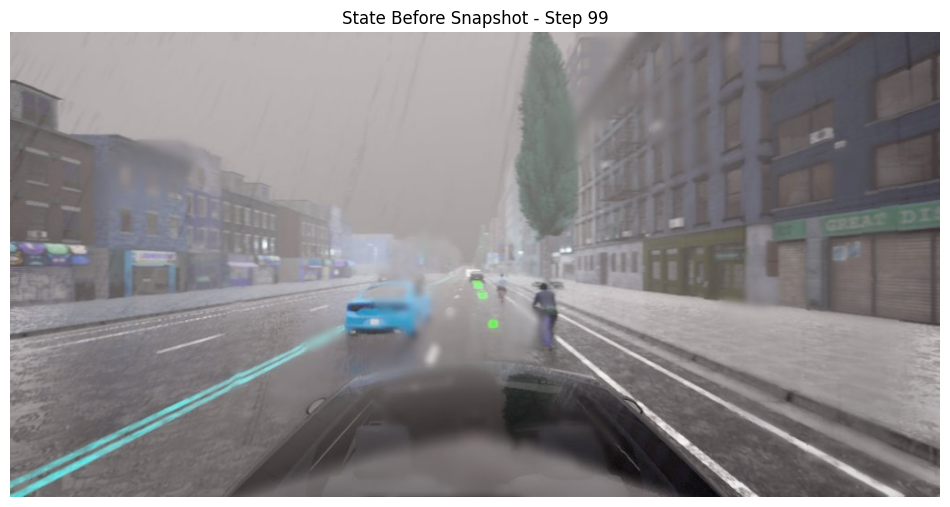

In [5]:
# Use pre-initialized state for exploration - exactly like test script (lines 475-477)
print("🚗 Starting initial exploration with pre-initialized state...")

if env.envs[0].last_observation is not None:
    # Use pre-initialized state
    obs = env.envs[0].last_observation
    info = {}
    print(f"Using pre-initialized state. Mode: {env.current_mode}, is_branching: {env.is_branching}")
else:
    # Reset environment if not pre-initialized
    print("Resetting environment for Phase 1...")
    obs, info = env.reset(options={"route_id": 0})
    print(f"Reset complete. Mode: {env.current_mode}, is_branching: {env.is_branching}")

trajectory = []
total_reward = 0.0

# Explore for 20 steps to reach a decision point
for step in range(100):
    # Vary actions to create an interesting scenario
    if step < 10:
        # First, move forward
        action = create_action(throttle=1.0, brake=0.0, steer=0.0)
    else:
        # Then add some steering variation
        action = create_action(throttle=1.0, brake=0.0, steer=0.3 * np.sin(step * 0.5))
    
    obs, reward, terminated, truncated, info = env.single_step(action)
    total_reward += reward
    
    trajectory.append({
        'step': step,
        'position': obs['vehicle_state']['position'],
        'speed': obs['vehicle_state']['speed'][0],
        'action': action.tolist(),
        'reward': reward,
        'image': obs['center_image'].copy()  # Store image for visualization
    })
    
    if step % 5 == 0:
        print(f"Step {step:2d}: pos=({obs['vehicle_state']['position'][0]:6.1f}, {obs['vehicle_state']['position'][1]:6.1f}), "
              f"speed={obs['vehicle_state']['speed'][0]:4.1f} m/s, reward={reward:.3f}")
    
    if terminated or truncated:
        print(f"🏁 Episode ended at step {step}")
        break

print(f"\n📊 Exploration completed:")
print(f"   Total steps: {len(trajectory)}")
print(f"   Total reward: {total_reward:.3f}")
print(f"   Final speed: {trajectory[-1]['speed']:.2f} m/s")

# Show final state before snapshot
plt.figure(figsize=(12, 8))
plt.imshow(trajectory[-1]['image'])
plt.title(f"State Before Snapshot - Step {len(trajectory)-1}")
plt.axis('off')
plt.show()

## 3. Snapshot System

Now let's explore the snapshot functionality - this is the core of GRPO's multi-turn rollout capability.

In [6]:
# Save current state for branching
print("💾 Saving snapshot for branching...")

try:
    snapshot_id = env.save_snapshot()
    print(f"✅ Snapshot saved successfully!")
    print(f"   Snapshot ID: {snapshot_id}")
    print(f"   Saved at step: {env.episode_steps}")
    print(f"   Current position: {trajectory[-1]['position']}")
    print(f"   Current speed: {trajectory[-1]['speed']:.2f} m/s")
    print(f"   Current mode: {env.current_mode}")
    print(f"   Is branching: {env.is_branching}")
except Exception as e:
    print(f"❌ Failed to save snapshot: {e}")
    print("💡 Make sure you're in single mode before saving snapshot")
    raise

INFO:carla_env:Saved snapshot: snap_service-0_0
INFO:grpo_carla_env:Saved snapshot 'snap_service-0_0' at step 100


💾 Saving snapshot for branching...
✅ Snapshot saved successfully!
   Snapshot ID: snap_service-0_0
   Saved at step: 100
   Current position: [ 541.44275 3911.658    371.23856]
   Current speed: 19.24 m/s
   Current mode: single
   Is branching: False


In [7]:
# Demonstrate snapshot information
print("📋 Snapshot System Information")
print("=" * 40)
print()
print("✅ What is a Snapshot?")
print("   A snapshot captures the complete state of the CARLA environment:")
print("   • Vehicle position and orientation")
print("   • Vehicle velocity and speed")
print("   • Traffic light states")
print("   • Weather and time of day")
print("   • Scenario progress and triggers")
print("   • Agent internal state")
print()
print("✅ Why Use Snapshots?")
print("   • Multi-turn rollouts: Explore from same state multiple times")
print("   • Decision points: Save at critical moments for branching")
print("   • Reproducibility: Replay exact scenarios")
print("   • GRPO optimization: Compare different action sequences")
print()
print(f"✅ Current Snapshot Status:")
print(f"   Snapshot ID: {snapshot_id}")
print(f"   Branch start step: {env.branch_start_step}")
print(f"   Can branch: {env.current_snapshot is not None}")
print(f"   Mode: {env.current_mode}")

📋 Snapshot System Information

✅ What is a Snapshot?
   A snapshot captures the complete state of the CARLA environment:
   • Vehicle position and orientation
   • Vehicle velocity and speed
   • Traffic light states
   • Weather and time of day
   • Scenario progress and triggers
   • Agent internal state

✅ Why Use Snapshots?
   • Multi-turn rollouts: Explore from same state multiple times
   • Decision points: Save at critical moments for branching
   • Reproducibility: Replay exact scenarios
   • GRPO optimization: Compare different action sequences

✅ Current Snapshot Status:
   Snapshot ID: snap_service-0_0
   Branch start step: 100
   Can branch: True
   Mode: single


INFO:grpo_carla_env:Enabling branching with 2 instances from snapshot 'snap_service-0_0'
INFO:grpo_carla_env:Restoring snapshot to branch 1...



🌿 Starting simple branching demonstration...
🌿 Enabling branching mode...


INFO:carla_env:Restored snapshot: snap_service-0_0 (cross-server, no local state)
INFO:grpo_carla_env:Branch 1 restored from snapshot
INFO:grpo_carla_env:Branching enabled with 2 active instances


✅ Branching enabled successfully!
   Active branches: 2
   Mode: branching

🧪 Running 15 steps with 2 branches...
   Branch 0: Straight driving
   Branch 1: Right turns
   Step 5: Branch 0 = 0.00, Branch 1 = 0.00
   Step 10: Branch 0 = 0.00, Branch 1 = 0.00
   Step 15: Branch 0 = 0.00, Branch 1 = 0.00
   Step 20: Branch 0 = 0.00, Branch 1 = 0.00
   Step 25: Branch 0 = 0.00, Branch 1 = 0.00
   Step 30: Branch 0 = 0.00, Branch 1 = 0.00

📸 Final Branch States:


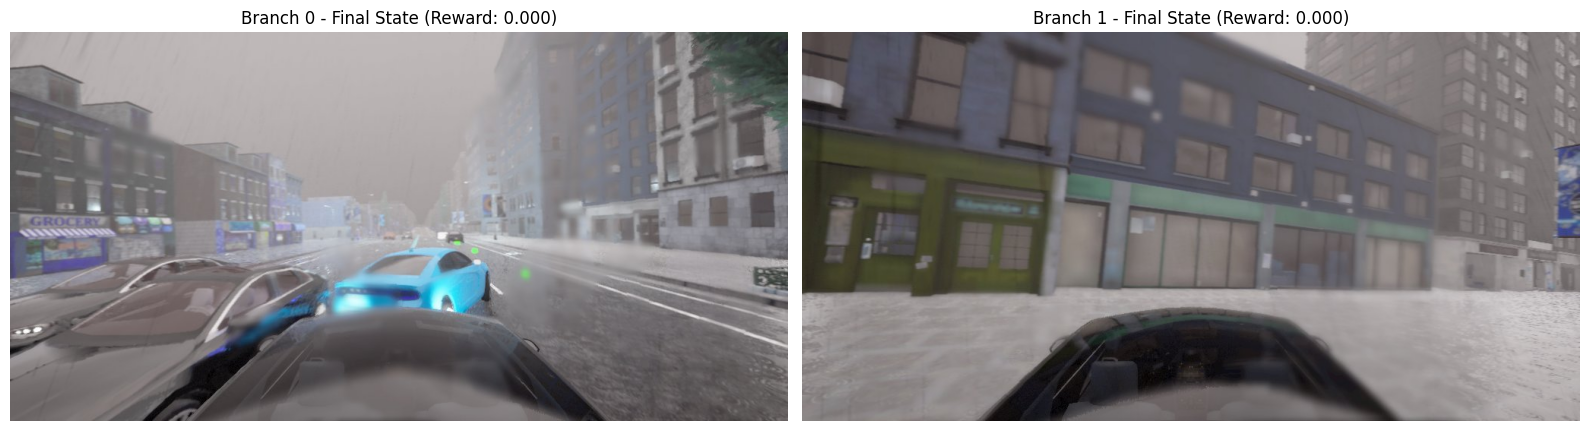


🏆 Branching Results:
   Branch 0 total reward: 0.000
   Branch 1 total reward: 0.000
   Ready for branch selection...


INFO:carla_env:Environment closed successfully
INFO:carla_env:Environment closed successfully


In [8]:
# 5. Simple Branching Demo
print("\n🌿 Starting simple branching demonstration...")

try:
    # Enable branching with 2 branches
    print("🌿 Enabling branching mode...")
    status = env.enable_branching(snapshot_id, num_branches=2, async_setup=False)
    
    if status.status.value == "branching_ready":
        print("✅ Branching enabled successfully!")
        print(f"   Active branches: {env.active_branches}")
        print(f"   Mode: {env.current_mode}")
        
        # Run 15 steps of branching
        print("\n🧪 Running 15 steps with 2 branches...")
        print("   Branch 0: Straight driving")
        print("   Branch 1: Right turns")
        
        total_rewards = [0, 0]
        branch_images = []
        
        for step in range(30):
            # Create different actions for each branch
            actions = [
                np.array([1.0, 0.0, 0.0], dtype=np.float32),   # Branch 0: Straight
                np.array([1.0, 0.0, 1.0], dtype=np.float32)    # Branch 1: Right turn
            ]
            
            # Execute branch step
            observations, rewards, terminateds, truncateds, infos = env.branch_step(actions)
            
            # Accumulate rewards
            for i in range(2):
                total_rewards[i] += rewards[i]
            
            # Store images for final display
            branch_images.append([obs['center_image'].copy() for obs in observations])
            
            # Show progress every 5 steps
            if (step + 1) % 5 == 0:
                print(f"   Step {step + 1}: Branch 0 = {total_rewards[0]:.2f}, Branch 1 = {total_rewards[1]:.2f}")
        
        # Show final images from both branches
        print("\n📸 Final Branch States:")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        for i in range(2):
            axes[i].imshow(branch_images[-1][i])
            axes[i].set_title(f"Branch {i} - Final State (Reward: {total_rewards[i]:.3f})")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Show results but don't select yet
        print("\n🏆 Branching Results:")
        print(f"   Branch 0 total reward: {total_rewards[0]:.3f}")
        print(f"   Branch 1 total reward: {total_rewards[1]:.3f}")
        print("   Ready for branch selection...")
        
    else:
        print(f"❌ Branching failed: {status.message}")
        
except Exception as e:
    print(f"❌ Error: {e}")
    raise

INFO:grpo_carla_env:Selecting branch 1 with cumulative reward: 0.00
INFO:grpo_carla_env:Returned to single mode with branch 1



🏆 Selecting best branch...
✅ Branch 1 selected - continuing in single mode

🚗 Continuing from Branch 1 for 30 steps to prove selection works...
   Step 0: pos=(529.7, 3905.9), speed=7.4 m/s
   Step 5: pos=(531.2, 3904.5), speed=9.5 m/s
   Step 10: pos=(533.3, 3903.0), speed=11.1 m/s
   Step 15: pos=(535.8, 3901.4), speed=12.5 m/s
   Step 20: pos=(538.2, 3900.0), speed=4.8 m/s
   Step 25: pos=(539.0, 3900.4), speed=2.0 m/s

📊 Continuation completed:
   Total steps: 30
   Total reward: 0.000

✅ PROOF: Successfully continued for 30 steps from selected branch 1!
   This proves the branch selection and continuation works correctly!


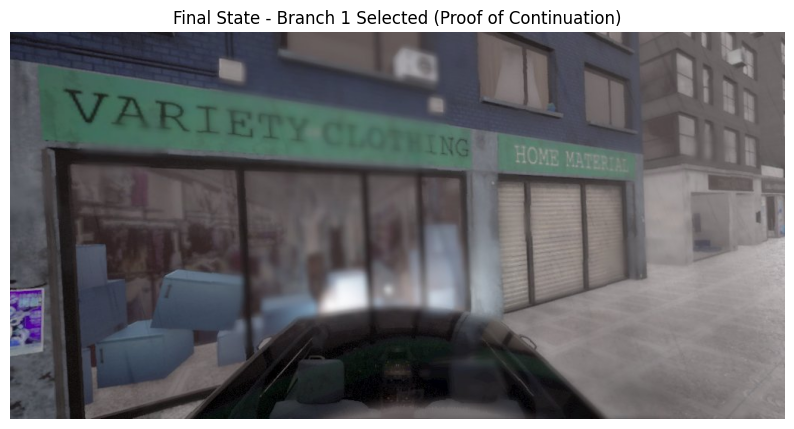

INFO:grpo_carla_env:GRPO environment closed



✅ Tutorial completed successfully!


In [10]:
# 6. Branch Selection
print("\n🏆 Selecting best branch...")

import numpy

# Select best branch based on rewards
best_branch = 1 #np.random.randint(0,2)

# Select the branch
env.select_branch(best_branch)
print(f"✅ Branch {best_branch} selected - continuing in single mode")

# 7. Continue from Selected Branch - Prove it works for many steps
print(f"\n🚗 Continuing from Branch {best_branch} for 30 steps to prove selection works...")

# Continue for 30 more steps to prove the selection works
continuation_reward = 0
for step in range(30):
    # Simple forward driving
    action = create_action(throttle=1.0, brake=0.0, steer=0.0)
    
    obs, reward, terminated, truncated, info = env.single_step(action)
    continuation_reward += reward
    
    if step % 5 == 0:
        pos = obs['vehicle_state']['position']
        speed = obs['vehicle_state']['speed'][0]
        print(f"   Step {step}: pos=({pos[0]:.1f}, {pos[1]:.1f}), speed={speed:.1f} m/s")
    
    # if terminated or truncated:
    #     print(f"   Episode ended at step {step}")
    #     break

print(f"\n📊 Continuation completed:")
print(f"   Total steps: {step + 1}")
print(f"   Total reward: {continuation_reward:.3f}")

print(f"\n✅ PROOF: Successfully continued for {step + 1} steps from selected branch {best_branch}!")
print(f"   This proves the branch selection and continuation works correctly!")

# Show final state
plt.figure(figsize=(10, 6))
plt.imshow(obs['center_image'])
plt.title(f"Final State - Branch {best_branch} Selected (Proof of Continuation)")
plt.axis('off')
plt.show()

# Clean up
env.close()
print("\n✅ Tutorial completed successfully!")